# 6.5 Beyond symmetry
see https://arxiv.org/abs/2305.00066

In [1]:
import numpy as np
from scipy.signal import convolve, convolve2d
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator as rgi
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from timeit import default_timer as tmr
from scipy.ndimage import gaussian_filter1d

In [2]:
from initial_conditions import Domain, Heaviside, LinearRamp, SmoothRamp, Sigmoid, CkRamp
from basis_functions import SVD, Trigonometric, Trigonometric2, TrigonometricOdd, Greedy, LNA, LPF, Sinc

In [3]:
import sys, numpy, scipy, matplotlib
print("Python version:", sys.version)
print("NumPy version:", numpy.__version__)
print("SciPy version:", scipy.__version__)
print("matplotlib version:", matplotlib.__version__)

Python version: 3.6.8 (default, May 31 2023, 10:28:59) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-18)]
NumPy version: 1.19.5
SciPy version: 1.5.4
matplotlib version: 3.3.4


In [4]:
m, n, r = 2500, 2500, 2500
s = 20  # steps

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = plt.cm.plasma
page_width_pt = 455.24
pt2in = 0.01389 
pt2cm = 0.0352777778
cm2in = 1/2.54
plot_width_in = page_width_pt*pt2in/2
print(plot_width_in/cm2in)

fs = 10
fs_lbl = 6
plt.rcParams["figure.figsize"] = (plot_width_in, plot_width_in/1.61803398875)
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.labelspacing'] = 0.0
plt.rcParams['legend.fontsize'] = fs_lbl
plt.rcParams['legend.handlelength'] = 1.0

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', size=12, serif='Computer Modern Roman')
pth = "../Plots/"

8.030570172000001


In [6]:
def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom')

In [7]:
def plot_f(y):
    xe = np.linspace(-1, 1, 2*m+1)
    xi = (xe[1:]+xe[:-1])/2

    fig, ax = plt.subplots()
    plt.plot(xi, y, "b--")
    plt.plot(xi, y, "b.")
    plt.grid()
    #ax.add_patch(Rectangle((0, -1), 1, 2, fc="grey", ec="k", lw=3, alpha=.2))
    draw_brace(ax, (0, 1), 0.0, "")
    ax.text(.5, 0.2, r'$\Omega$', fontdict={"fontsize": 16, "ha": "center"})
    ax.text(-.4, 0.03, r'inflow', fontdict={"fontsize": 10})
    ax.annotate("", xy=(-0.0, 0.0), xytext=(-.4, 0), arrowprops=dict(arrowstyle="->"))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f(x)$")
    ax.set_ylim([-1, 1])
    #plt.show()
    return fig, ax

## make a random initial condition

In [8]:
def make_random_IC(s=20):
    xe = np.linspace(-1, 1, s+1)
    xm = (xe[1:]+xe[:-1])/2
    steps = np.random.rand(s,)*2-1


    interp  = rgi([xm, ], steps, method="nearest", bounds_error=False, fill_value=None)
    xe = np.linspace(-1, 1, 2*m+1)
    xi = (xe[1:]+xe[:-1])/2
    y = interp(xi)
    
    plot_f(y)
    #plt.plot(xm, steps, "ro")
    plt.show()

    return y

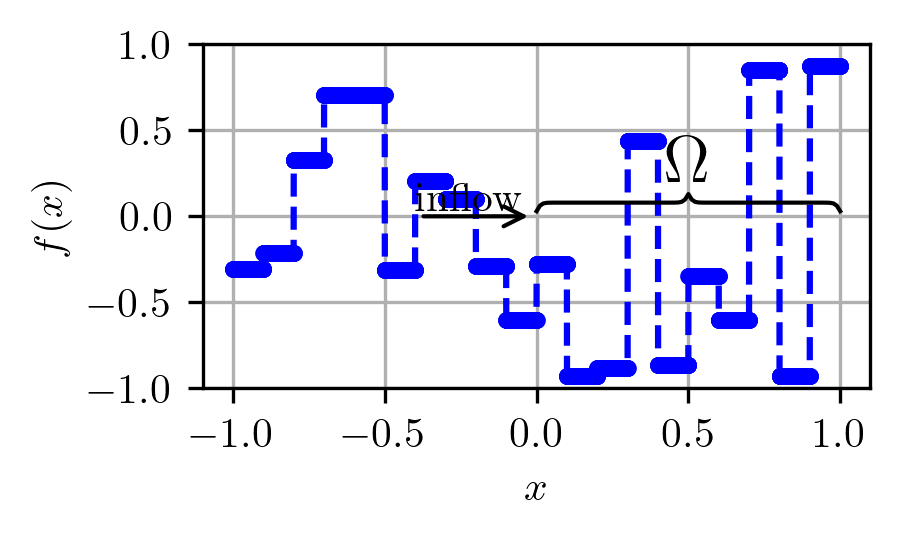

In [9]:
f = make_random_IC(s=s)

## k- fold convolution, SVD and error computation
kernel width: at least max distance between discontinuities to increase degree of smoothness


In [10]:
p = 25

print(f.shape)
d_Ns = {}
delta_Ns = {}
f_convolved = {}

kernel_width = 2*m/s  # 1%
print(m, s, kernel_width)
kernel_width = np.int32(kernel_width)
print(kernel_width)
kernel = np.ones(kernel_width) / kernel_width

xe = np.linspace(-1, 1, 2*m+1)
xi = (xe[1:]+xe[:-1])/2

n_padding = 5*kernel_width
f_convolved[0] = np.zeros((2*m+2*n_padding))
f_convolved[0][n_padding:-n_padding] = f.copy()

for k in range(5):
    t0 = tmr()
    fk = f_convolved[k][n_padding:-n_padding]
    Xk = np.zeros((m, n))
    for j in range(n):
        Xk[:, j] = fk[(m-j):(m-j+m)]

    t1 = tmr()
    print("snapshot matrix made", t1-t0)
    svd_basis = SVD(Xk)
    t2 = tmr()
    print("SVD'ed", t2-t1)
    delta_n, d_n = svd_basis.calc_error()
    t3 = tmr()
    print("error calculated", t3-t2)
    d_Ns[k] = d_n
    delta_Ns[k] = delta_n
    
    #_fk_ = gaussian_filter1d(f_convolved[k], 5, mode="wrap")
    f_convolved[k+1] = convolve(f_convolved[k], kernel, 'same')
    t4 = tmr()
    print("convolved", t4-t3)

(5000,)
2500 20 250.0
250
snapshot matrix made 0.19087046198546886
SVD'ed 25.218109216541052
error calculated 0.00033709220588207245
convolved 0.0015370659530162811
snapshot matrix made 0.07767237536609173
SVD'ed 18.60008309595287
error calculated 0.00031405873596668243
convolved 0.0010038018226623535
snapshot matrix made 0.08519990183413029
SVD'ed 13.157567724585533
error calculated 0.0006863214075565338
convolved 0.00048218294978141785
snapshot matrix made 0.11269446462392807
SVD'ed 10.819883024320006
error calculated 0.0005258247256278992
convolved 0.0005146674811840057
snapshot matrix made 0.0671401396393776
SVD'ed 14.755701353773475
error calculated 0.00023737922310829163
convolved 0.0009483937174081802


## Fig. 6a: Piecewise constant with 20 random steps (dark blue); increasing smoothness Ck(ΩP ) by k + 1-fold convolution, k = 0, ..., 3.
and numerical computation of the k-th derivative to check its smoothness

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


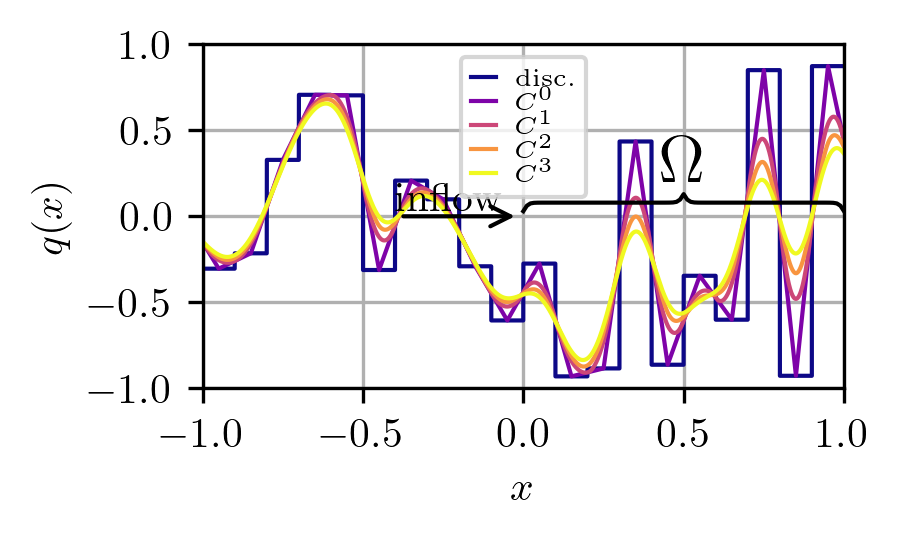

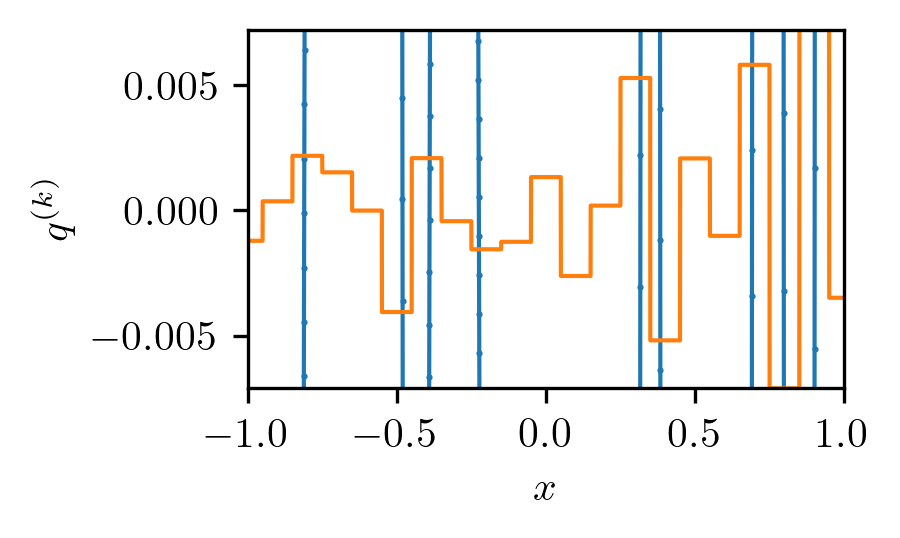

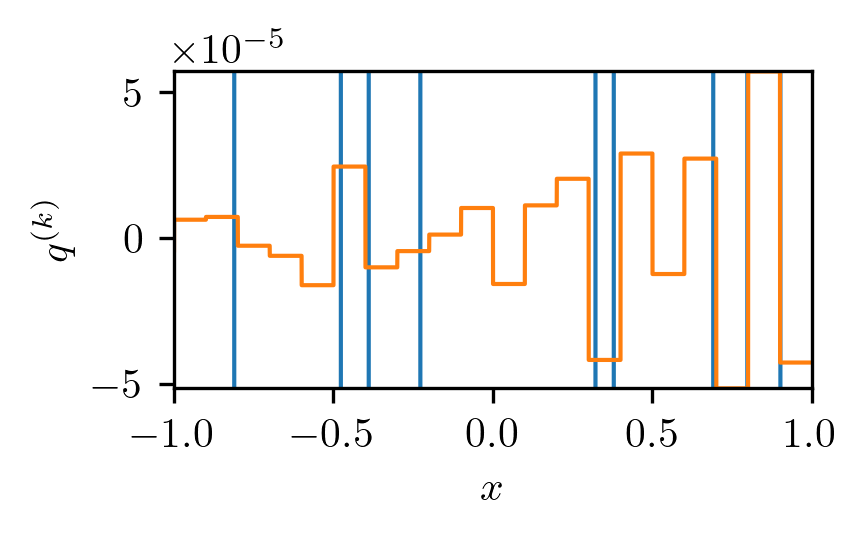

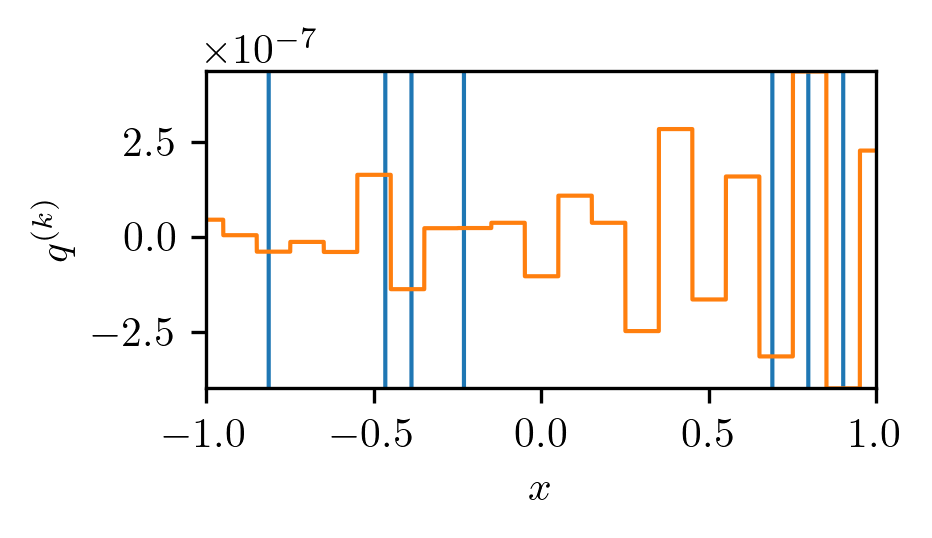

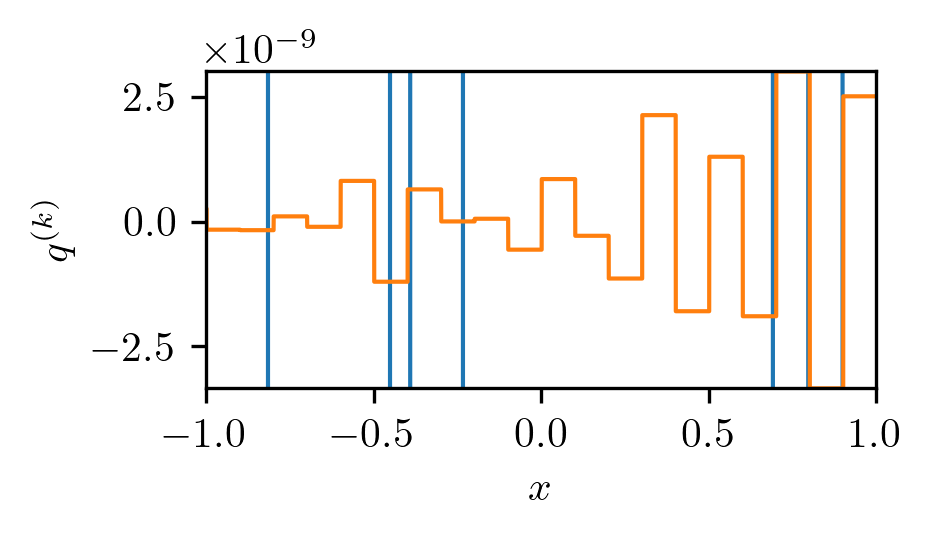

In [11]:
def ddx(y, n=1):
    derivative = y
    for i in range(n):
        derivative = np.diff(derivative, prepend=0)
    return derivative

fig_fk, ax_fk = plt.subplots(tight_layout=True)

for k in range(5):
    if k == 0:
        lbl = "disc."
    else:
        lbl = "$C^{:.0f}$".format(k-1)

    fk = f_convolved[k][n_padding:-n_padding]
    ax_fk.plot(xi, fk, "-", ms=1, lw=1, color=cmap(k/4), label=lbl)
    if k != 0:
        fig, ax_ddx = plt.subplots()
        ax_ddx.plot(xi, fk, ".-", ms=1, lw=1)
        for ki in range(1, k+1):
            derivative_N = ddx(f_convolved[k], ki)[n_padding:-n_padding]
        ax_ddx.plot(xi, derivative_N, "-", ms=1, lw=1)
        ax_ddx.set_xlim([-1, 1])
        ax_ddx.set_ylim([derivative_N.min(), derivative_N.max()])
        ax_ddx.set_xlabel("$x$")
        ax_ddx.set_ylabel("$q^{(k)}$")

ax_fk.grid(which="both")
#ax.add_patch(Rectangle((0, -1), 1, 2, fc="grey", ec="k", lw=3, alpha=.2))
draw_brace(ax_fk, (0, 1), 0.0, "")
ax_fk.text(.5, 0.2, r'$\Omega$', fontdict={"fontsize": 16, "ha": "center"})
ax_fk.text(-.4, 0.03, r'inflow', fontdict={"fontsize": 10})
ax_fk.annotate("", xy=(-0.0, 0.0), xytext=(-.4, 0), arrowprops=dict(arrowstyle="->"))
ax_fk.set_xlabel("$x$")
ax_fk.set_ylabel("$q(x)$")
ax_fk.set_xlim([-1, 1])
ax_fk.set_ylim([-1, 1])
ax_fk.legend()
fig_fk.savefig(pth+"randomIC_1.pdf")

## Fig. 6 (b) N -width decay for discontinuous function and g ∈ Ck(ΩP ), k = 0, ..., 3.

1.2760015815784351
12.881374895301745
159.092352828875
2167.977906219451
31002.15916879283


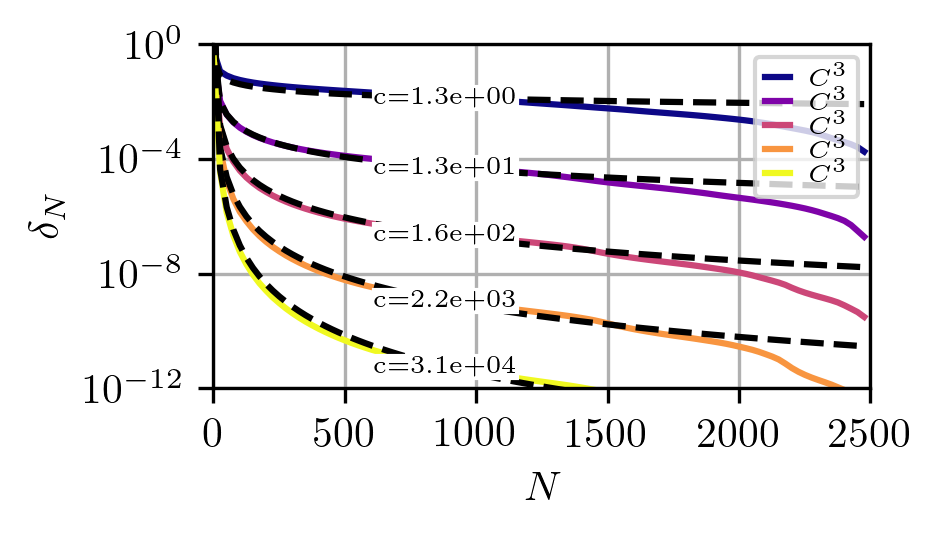

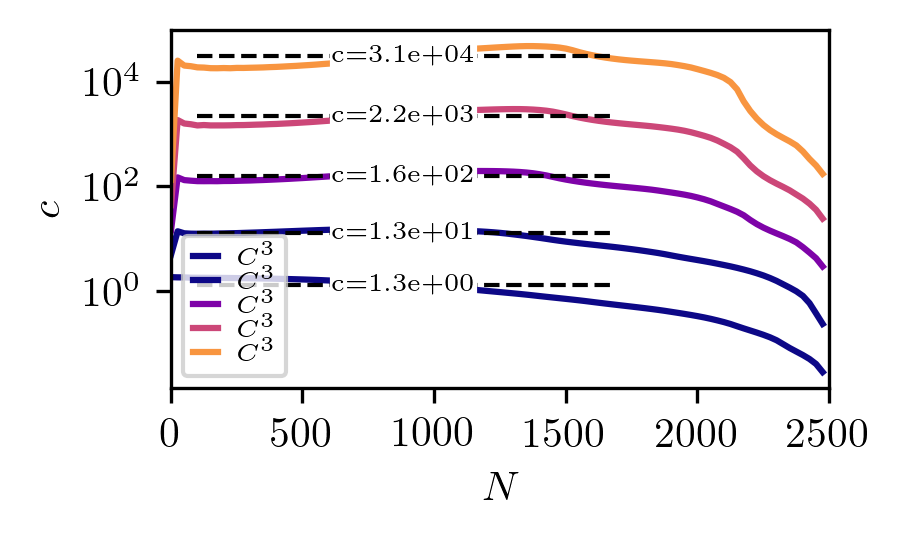

In [12]:
p = 25
    
fig_dN, ax_dN = plt.subplots(tight_layout=True)
fig_d_est, ax_d_est = plt.subplots(tight_layout=True)

for k in range(5):

    d_n = d_Ns[k]
    delta_n = delta_Ns[k]

    N = np.arange(len(delta_n))+1
    ax_dN.plot(N[::p], delta_n[::p], "-", color=cmap(k/4), label=lbl)
    
    k = k-1
    model = 1/np.pi**(k+2) * N**(-(2*k+3)/2)
    C = delta_n/model
    C_estimated = np.mean(C[100: r//3*2])
    print(C_estimated)
    #ax.plot(N, C_estimated*model, "k--", lw=1, ms=0)

    ax_d_est.plot(N[::p], C[::p], "-", color=cmap(k/4), label=lbl)
    ax_d_est.plot([100, r/3*2], [C_estimated, C_estimated], "k--", lw=1)
    ltex = ax_d_est.text(r/3+50, C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))
    ax_dN.plot(N[::p], model[::p]*C_estimated, "k--")
    ltex = ax_dN.text(r//3+50, model[r//3+50]*C_estimated, "c={:.1e}".format(C_estimated), size=6, color="k",
                         ha="center", va="center", bbox=dict(ec='1',fc='1', pad=0))

ax_dN.set_ylim([1e-12, 1e+0])
ax_dN.set_xlim([0, r]) 
ax_dN.set_yscale('log')
ax_dN.legend()
ax_dN.set_xlabel(r'$N$')
ax_dN.set_ylabel(r'$\delta_N$')
ax_dN.grid(which="both")


plt.tight_layout()

ax_d_est.legend()
ax_d_est.set_yscale('log')
ax_d_est.set_xlim([0, r])
#ax_d_est.set_ylim([0, 10])
ax_d_est.set_xlabel(r'$N$')
ax_d_est.set_ylabel(r'$c$')

fig_dN.savefig(pth+"random_1D_decay.pdf")

plt.show()

In [13]:
delta_Ns[0].shape

(2500,)

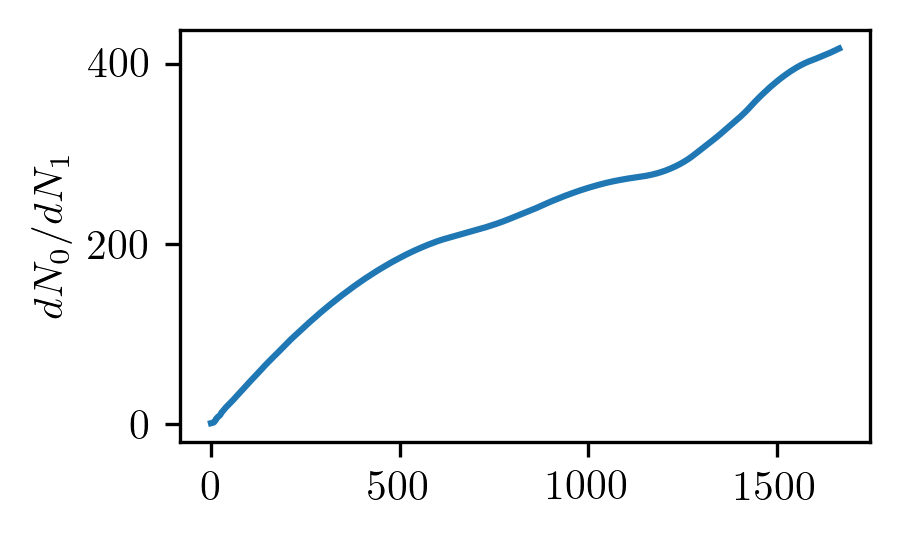

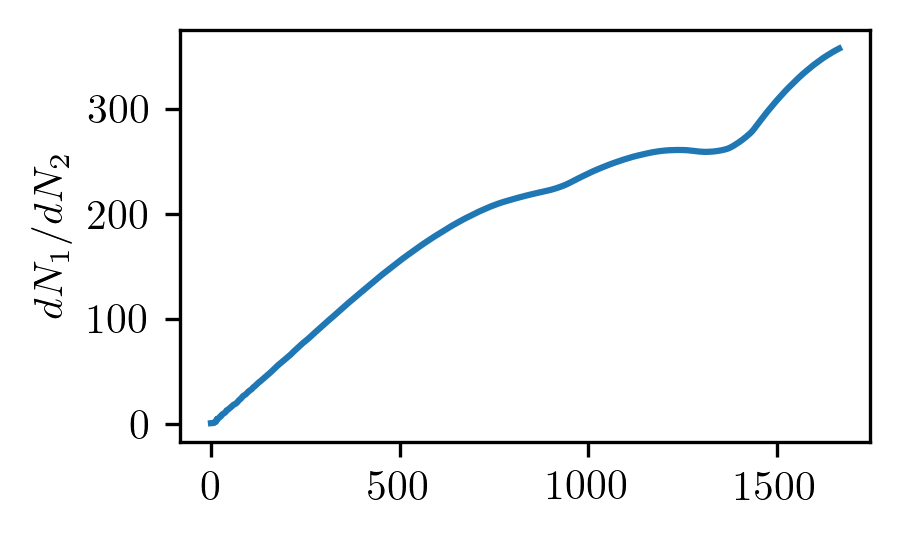

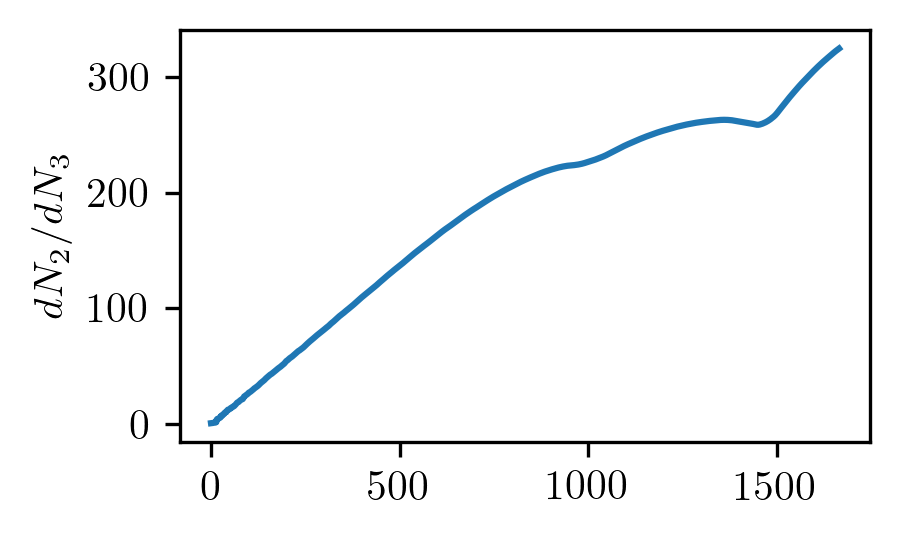

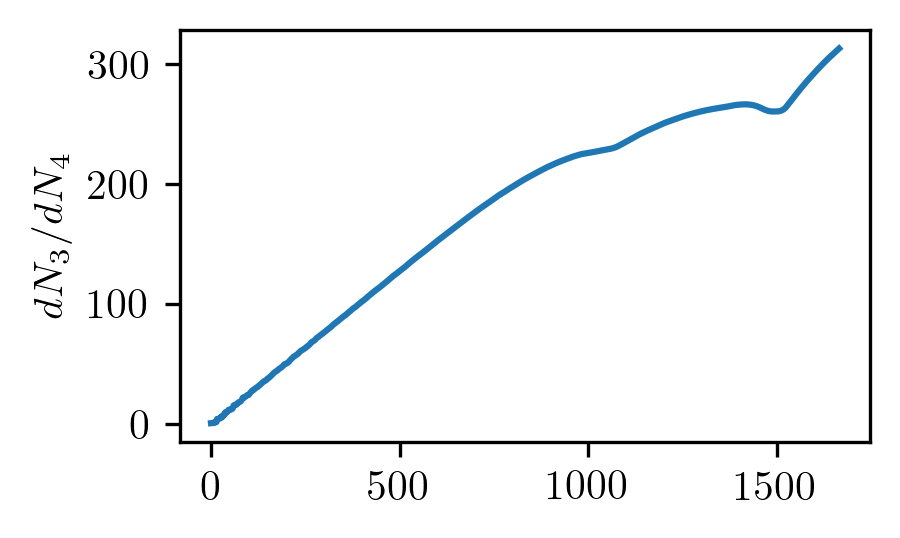

In [17]:
N = np.arange(r//3*2)
for i in range(4):
    fig, ax = plt.subplots()
    plt.plot(N, (delta_Ns[i]/delta_Ns[i+1])[N])
    #plt.xlim(0, 750)
    #plt.ylim(0, 25)
    plt.ylabel(r"$dN_{:.0f}/dN_{:.0f}$".format(i, i+1))
    plt.show()
